In [2]:
import json
import efel
import pandas
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 8})
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [24]:
def plot_traces(path, prefix, protocol, channels, recordings,
                vshift=0, title=None, figsize=(12, 8)):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize)
    ax1.set_ylabel('Voltage (mV)')
    ax2.set_ylabel('Current (pA)')
    ax2.set_xlabel('Time (ms)')
    if not title:
        title = protocol
    fig.suptitle(title)
    if len(recordings) > 1:
        color_cycle = [plt.cm.Blues(i) 
                       for i in np.linspace(0.3, 1, len(recordings))**2]
        ax1.set_prop_cycle('color', color_cycle)
        ax2.set_prop_cycle('color', color_cycle)
    for rec in reversed(recordings):
        fullname = path + '/' + prefix + '_' + protocol \
            + '_ch' + str(channels['current']) + '_' + str(rec) + '.dat'
        data = np.loadtxt(fullname)
        time = data[:, 0]
        current = data[:, 1]
        fullname = path + '/' + prefix + '_' + protocol \
            + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
        data = np.loadtxt(fullname)
        voltage = data[:, 1] - vshift
        ax1.plot(time, voltage)
        ax2.plot(time, current)
    return fig


def get_currents(path, prefix, protocol, channels, recordings, timing):
    currents = []
    for rec in recordings:
        print(rec)
        fullname = path + '/' + prefix + '_' + protocol \
            + '_ch' + str(channels['current']) + '_' + str(rec) + '.dat'
        data = np.loadtxt(fullname)
        time = data[:, 0]
        current = data[:, 1]
        hold = current[np.where(time < timing['stimulus_start'])].mean()
        stim = current[np.where((timing['stimulus_start'] < time) 
                        & (time < timing['stimulus_end']))].mean()
        current = {}
        current['sweep'] = protocol + '_' + str(rec)
        current['holding_current_amp'] = hold
        current['holding_current_start'] = time[0]
        current['holding_current_end'] = time[-1]
        current['stimulus_total_amp'] = stim
        current['stimulus_amp'] = stim - hold
        current['stimulus_start'] = timing['stimulus_start']
        current['stimulus_end'] = timing['stimulus_end']
        currents.append(current)
    return currents


def extract(features, path, prefix, protocol, channels, recordings, timing,
            vshift=0, input_resistance=False):    
    stimuli = get_currents(path, prefix, protocol, channels, recordings, timing)
    traces = []
    for rec in recordings:
        # print(rec) #ok 
        fullname = path + '/' + prefix + '_' + protocol \
            + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
        data = np.loadtxt(fullname)
        time = data[:, 0]
        voltage = data[:, 1] - vshift
        trace = {}
        trace['T'] = time
        trace['V'] = voltage
        trace['stim_start'] = [timing['stimulus_start']]
        trace['stim_end'] = [timing['stimulus_end']]
        traces.append(trace)
    if input_resistance:
        pA = 1e-12
        mV = 1e-3
        MOhm = 1e6
        efel.set_setting('stimulus_current', 
                            stimuli[0]['stimulus_amp']/(mV/pA/MOhm))
    feature_values = efel.get_feature_values(traces, features)
    res = [(s, f) for s, f in zip(stimuli, feature_values)]
    print(res)
    return res


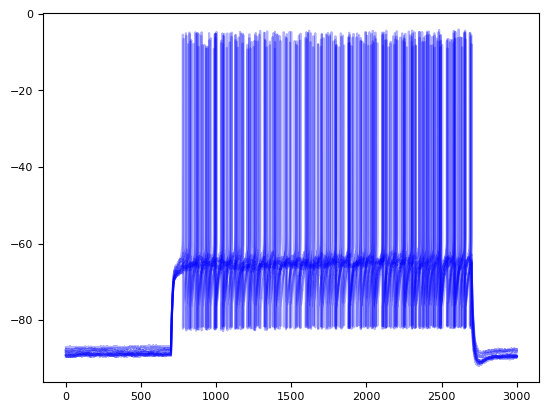

In [25]:
from scipy.signal import find_peaks

cell_type = 'FS'
cell_path = 'fs/derived/'
cell_id = '180418_FS5'
cell = cell_path + cell_id
prefix = 'ECall'
channels = {'current': 6, 'voltage': 7}
liquid_junction_potential = 9.5

spec = {}
spec['cell_id'] = cell_id
spec['cell_type'] = cell_type
spec['cell_features'] = {}
spec['temperature'] = 35
spec['liquid_junction_potential'] = liquid_junction_potential

protocol = 'IDthresh'
feature_protocol = protocol
path = cell
vshift=0
input_resistance=False

list_rec = []
for rec in  range(1925, 1945):
    fullname = path + '/' + prefix + '_' + protocol \
    + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
    data = np.loadtxt(fullname)
    time = data[:, 0]
    voltage = data[:, 1]
    peak_tuple = find_peaks(voltage, height= -30)
    if peak_tuple[0].size > 1:
        list_rec.append(rec)
        plt.plot(time,voltage, 'b', alpha=0.3)
plt.show()
        

In [26]:
repetitions = [list_rec]  
print(list_rec)
features_train = ['AHP_depth', 'AHP_depth_abs', 'AHP_depth_abs_slow',
                  'AHP_slow_time', 'AHP_time_from_peak', 'AP_amplitude',
                  'AP_begin_voltage', 'AP_fall_rate', 'AP_rise_rate', 
                  'ISI_CV', 'Spikecount', 'adaptation_index2', 
                  'inv_first_ISI', 'mean_frequency',
                  'min_voltage_between_spikes', 'peak_voltage',
                  'spike_half_width', 'steady_state_voltage', 
                  'time_to_first_spike', 'voltage_base']
features = features_train

spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, path, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 1100},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)
print(spec['cell_features'][feature_protocol])

[1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944]
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
[({'sweep': 'IDthresh_1934', 'holding_current_amp': 248.36, 'holding_current_start': 0.0, 'holding_current_end': 2999.9, 'stimulus_total_amp': 347.4408065806581, 'stimulus_amp': 99.08080658065808, 'stimulus_start': 100, 'stimulus_end': 1100}, {'AHP_depth': array([5.376614, 5.182814, 5.614014, 5.270314, 5.282814]), 'AHP_depth_abs': array([-91.3812, -91.575 , -91.1438, -91.4875, -91.475 ]), 'AHP_depth_abs_slow': array([-85.5938, -85.1437, -85.5188]), 'AHP_slow_time': array([0.05204082, 0.06351183, 0.03502747]), 'AHP_time_from_peak': array([0.6, 0.6, 0.6, 0.6, 0.6]), 'AP_amplitude': None, 'AP_begin_voltage': array([-66.79380001, -65.76880001, -66.50630001, -67.37500001,
       -66.52500001]), 'AP_fall_rate': array([-129.16658309, -129.583333  , -153.7499997 , -129.66666639,
       -151.54999982]), 'AP_rise_rate': array([132.28137466, 173.14599939, 130.9844997 , 134.218

/home/abonard/anaconda3/lib/python3.12/site-packages/efel/pyfeatures/cppfeature_access.py:14: RuntimeWarning: Error while calculating AP_amplitude, Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting functio

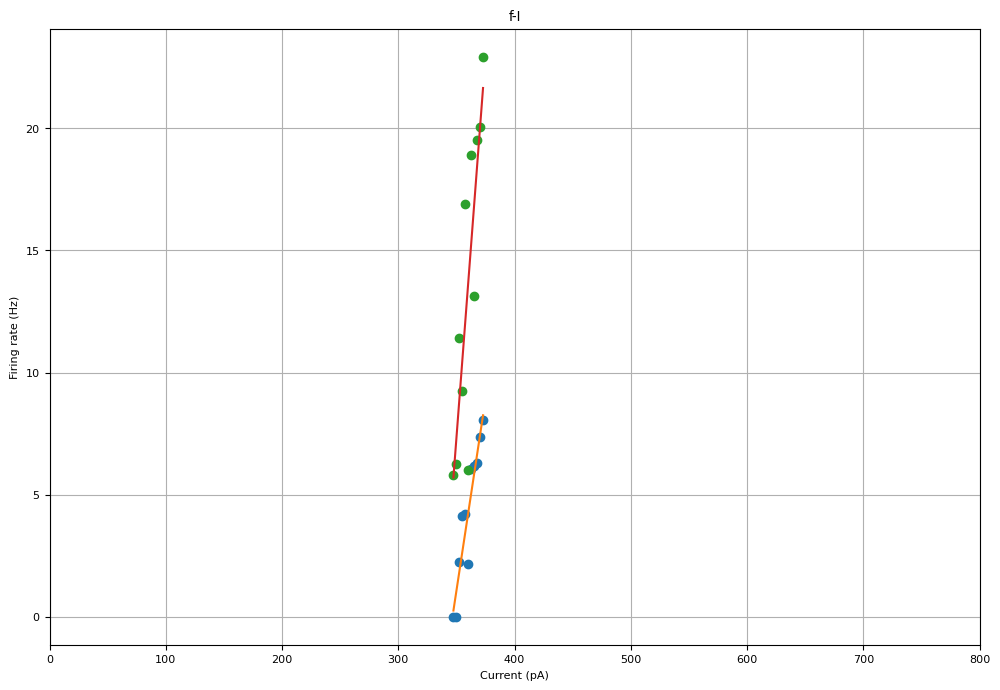

In [27]:
f_i = []
f_i1 = []
for stim, feat in spec['cell_features']['IDthresh']:
    f_i.append((stim['stimulus_total_amp'], feat['mean_frequency'][0]))
    f_i1.append((stim['stimulus_total_amp'], feat['inv_first_ISI'][0]))
f_i.sort(key=lambda x: x[0])
f_i1.sort(key=lambda x: x[0])

fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('f-I')
ax.grid()
xx = np.array([x[0] for x in f_i])
yy = np.array([x[1] for x in f_i])
p = np.polyfit(xx, yy, 1)
ax.plot(xx, yy, 'o')
ax.plot(xx, p[1]+p[0]*xx, '-')
x1 = np.array([x[0] for x in f_i1])
y1 = np.array([x[1] for x in f_i1])
p1 = np.polyfit(x1, y1, 1)
ax.plot(x1, y1, 'o')
ax.plot(x1, p1[1]+p1[0]*x1, '-')
plt.xlim(0,800)
plt.show()

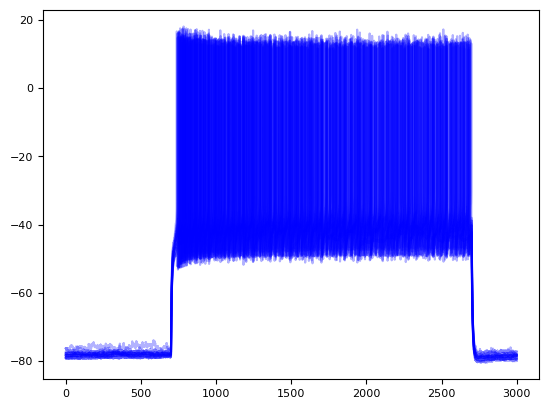

[527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542]
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542


/home/abonard/anaconda3/lib/python3.12/site-packages/efel/pyfeatures/cppfeature_access.py:14: RuntimeWarning: Error while calculating adaptation_index2, Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
An error occurred while computing the feature, feature is not found. At least 4 spikes within stimulus interval nee

[({'sweep': 'IDthresh_527', 'holding_current_amp': 8.07, 'holding_current_start': 0.0, 'holding_current_end': 2999.9, 'stimulus_total_amp': 102.00176267626763, 'stimulus_amp': 93.93176267626762, 'stimulus_start': 100, 'stimulus_end': 1100}, {'AHP_depth': array([24.005359, 24.299059, 24.036559, 24.774059, 24.461559, 24.717759]), 'AHP_depth_abs': array([-61.3312, -61.0375, -61.3   , -60.5625, -60.875 , -60.6188]), 'AHP_depth_abs_slow': array([-58.4125, -59.0125, -59.3188, -58.425 ]), 'AHP_slow_time': array([0.02185315, 0.01636189, 0.03469388, 0.01706256]), 'AHP_time_from_peak': array([1. , 1.1, 1.2, 1.2, 1.2, 1. ]), 'AP_amplitude': array([52.14379999, 50.83129997]), 'AP_begin_voltage': array([-44.8688    , -43.21879999, -43.525     , -42.        ,
       -42.425     , -43.16250001]), 'AP_fall_rate': array([-84.75774999, -84.89849998, -82.086     , -83.24999996,
       -83.78124993, -84.32812489]), 'AP_rise_rate': array([173.81266663, 169.43766657, 164.646     , 163.35399992,
       165.5

In [28]:
from scipy.signal import find_peaks

cell_type = 'FS'
cell_path = 'fs/derived/'
cell_id = '160628_FS2'
cell = cell_path + cell_id
prefix = 'ECall'
channels = {'current': 4, 'voltage': 5}
liquid_junction_potential = 9.5

spec = {}
spec['cell_id'] = cell_id
spec['cell_type'] = cell_type
spec['cell_features'] = {}
spec['temperature'] = 35
spec['liquid_junction_potential'] = liquid_junction_potential

protocol = 'IDthresh'
feature_protocol = protocol
path = cell
vshift=0
input_resistance=False

list_rec = []
for rec in  range(522, 543):
    fullname = path + '/' + prefix + '_' + protocol \
    + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
    data = np.loadtxt(fullname)
    time = data[:, 0]
    voltage = data[:, 1]
    peak_tuple = find_peaks(voltage, height= -30)
    if peak_tuple[0].size > 1:
        list_rec.append(rec)
        plt.plot(time,voltage, 'b', alpha=0.3)
plt.show()

repetitions = [list_rec]  
print(list_rec)
features_train = ['AHP_depth', 'AHP_depth_abs', 'AHP_depth_abs_slow',
                  'AHP_slow_time', 'AHP_time_from_peak', 'AP_amplitude',
                  'AP_begin_voltage', 'AP_fall_rate', 'AP_rise_rate', 
                  'ISI_CV', 'Spikecount', 'adaptation_index2', 
                  'inv_first_ISI', 'mean_frequency',
                  'min_voltage_between_spikes', 'peak_voltage',
                  'spike_half_width', 'steady_state_voltage', 
                  'time_to_first_spike', 'voltage_base']
features = features_train

spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, path, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 1100},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)
print(spec['cell_features'][feature_protocol])    

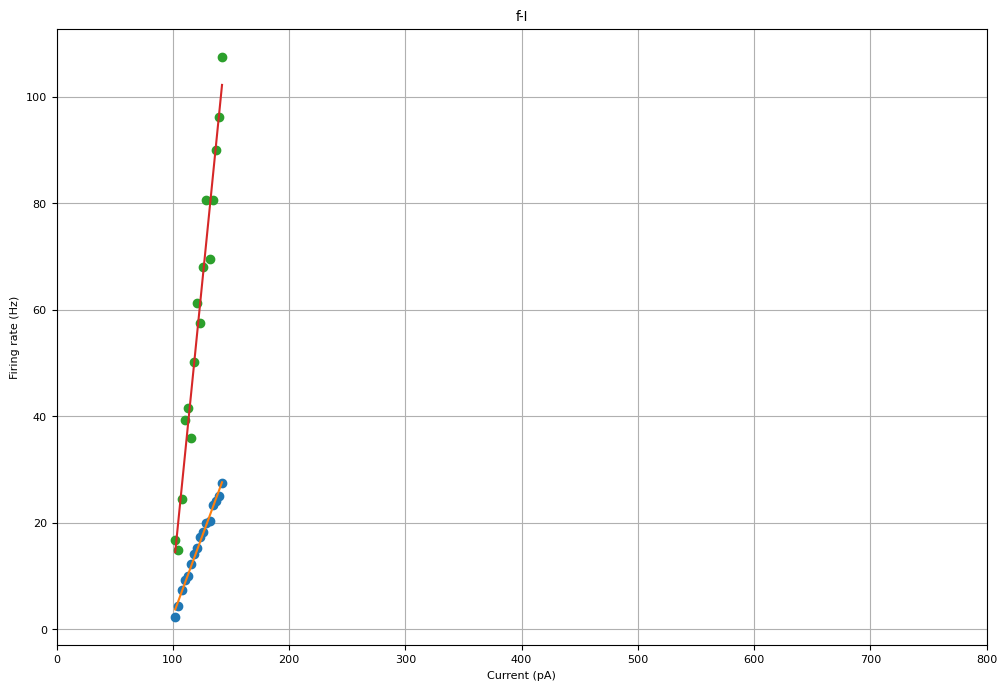

In [29]:
f_i2 = []
f_i12 = []
for stim, feat in spec['cell_features']['IDthresh']:
    f_i2.append((stim['stimulus_total_amp'], feat['mean_frequency'][0]))
    f_i12.append((stim['stimulus_total_amp'], feat['inv_first_ISI'][0]))
f_i2.sort(key=lambda x: x[0])
f_i12.sort(key=lambda x: x[0])

fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('f-I')
ax.grid()
xx = np.array([x[0] for x in f_i2])
yy = np.array([x[1] for x in f_i2])
p = np.polyfit(xx, yy, 1)
ax.plot(xx, yy, 'o')
ax.plot(xx, p[1]+p[0]*xx, '-')
x1 = np.array([x[0] for x in f_i12])
y1 = np.array([x[1] for x in f_i12])
p1 = np.polyfit(x1, y1, 1)
ax.plot(x1, y1, 'o')
ax.plot(x1, p1[1]+p1[0]*x1, '-')
plt.xlim(0,800)
plt.show()

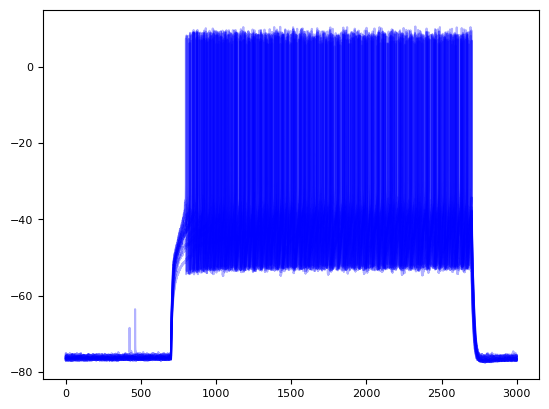

[520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538]
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538


/home/abonard/anaconda3/lib/python3.12/site-packages/efel/pyfeatures/cppfeature_access.py:14: RuntimeWarning: Error while calculating AP_amplitude, Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting functio

[({'sweep': 'IDthresh_520', 'holding_current_amp': 199.761875, 'holding_current_start': 0.0, 'holding_current_end': 2999.9, 'stimulus_total_amp': 267.95123262326234, 'stimulus_amp': 68.18935762326234, 'stimulus_start': 100, 'stimulus_end': 1100}, {'AHP_depth': array([21.567436, 22.673636, 21.948736, 22.373736, 22.073636, 22.342436,
       22.004936, 21.661136, 22.242436, 22.179936]), 'AHP_depth_abs': array([-64.075 , -62.9688, -63.6937, -63.2687, -63.5688, -63.3   ,
       -63.6375, -63.9813, -63.4   , -63.4625]), 'AHP_depth_abs_slow': array([-63.6562, -63.9375, -63.6313, -63.7125, -63.2125, -64.0312,
       -64.2125, -63.4375]), 'AHP_slow_time': array([0.03390957, 0.04946728, 0.04691812, 0.04753962, 0.04039634,
       0.04299481, 0.05018248, 0.05195843]), 'AHP_time_from_peak': array([2.9, 2.1, 3.6, 2.6, 3.2, 2.9, 3. , 3.9, 3.8, 2.9]), 'AP_amplitude': None, 'AP_begin_voltage': array([-39.7188    , -40.6375    , -41.5187    , -39.63750001,
       -39.83750001, -39.87500001, -43.03120001

In [30]:
from scipy.signal import find_peaks

cell_type = 'FS'
cell_path = 'fs/derived/'
cell_id = '161024_FS16'
cell = cell_path + cell_id
prefix = 'ECall'
channels = {'current': 0, 'voltage': 1}
liquid_junction_potential = 9.5

spec = {}
spec['cell_id'] = cell_id
spec['cell_type'] = cell_type
spec['cell_features'] = {}
spec['temperature'] = 35
spec['liquid_junction_potential'] = liquid_junction_potential

protocol = 'IDthresh'
feature_protocol = protocol
path = cell
vshift=0
input_resistance=False

list_rec = []
for rec in  range(518, 539):
    fullname = path + '/' + prefix + '_' + protocol \
    + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
    data = np.loadtxt(fullname)
    time = data[:, 0]
    voltage = data[:, 1]
    peak_tuple = find_peaks(voltage, height= -30)
    if peak_tuple[0].size > 1:
        list_rec.append(rec)
        plt.plot(time,voltage, 'b', alpha=0.3)
plt.show()

repetitions = [list_rec]  
print(list_rec)
features_train = ['AHP_depth', 'AHP_depth_abs', 'AHP_depth_abs_slow',
                  'AHP_slow_time', 'AHP_time_from_peak', 'AP_amplitude',
                  'AP_begin_voltage', 'AP_fall_rate', 'AP_rise_rate', 
                  'ISI_CV', 'Spikecount', 'adaptation_index2', 
                  'inv_first_ISI', 'mean_frequency',
                  'min_voltage_between_spikes', 'peak_voltage',
                  'spike_half_width', 'steady_state_voltage', 
                  'time_to_first_spike', 'voltage_base']
features = features_train

spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, path, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 1100},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)
print(spec['cell_features'][feature_protocol])    

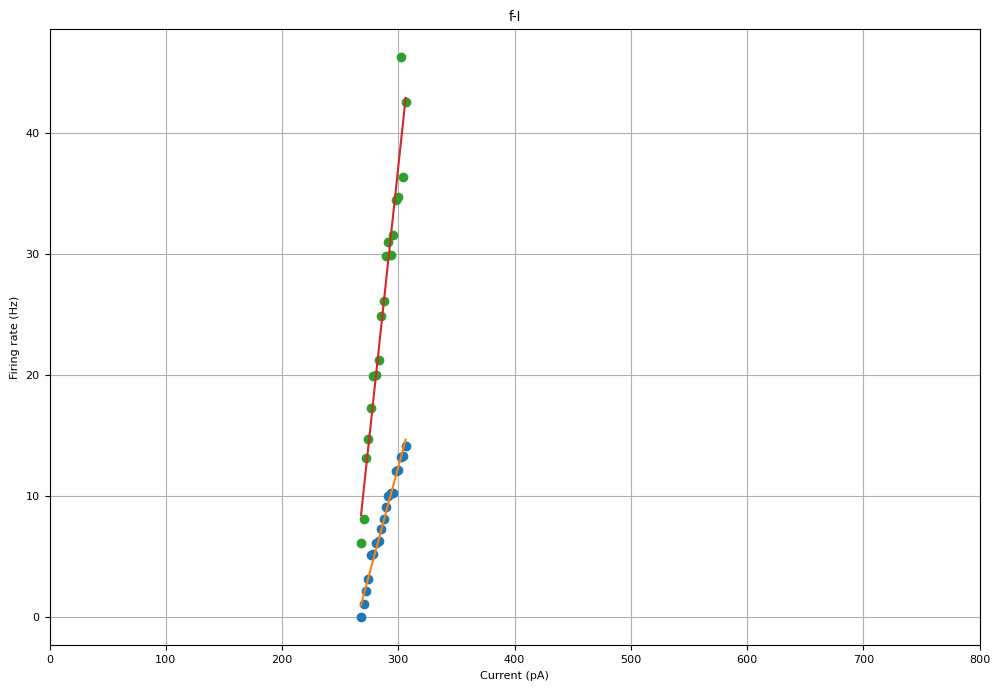

In [31]:
f_i3 = []
f_i13 = []
for stim, feat in spec['cell_features']['IDthresh']:
    f_i3.append((stim['stimulus_total_amp'], feat['mean_frequency'][0]))
    f_i13.append((stim['stimulus_total_amp'], feat['inv_first_ISI'][0]))
f_i3.sort(key=lambda x: x[0])
f_i13.sort(key=lambda x: x[0])

fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('f-I')
ax.grid()
xx = np.array([x[0] for x in f_i3])
yy = np.array([x[1] for x in f_i3])
p = np.polyfit(xx, yy, 1)
ax.plot(xx, yy, 'o')
ax.plot(xx, p[1]+p[0]*xx, '-')
x1 = np.array([x[0] for x in f_i13])
y1 = np.array([x[1] for x in f_i13])
p1 = np.polyfit(x1, y1, 1)
ax.plot(x1, y1, 'o')
ax.plot(x1, p1[1]+p1[0]*x1, '-')
plt.xlim(0,800)
plt.show()

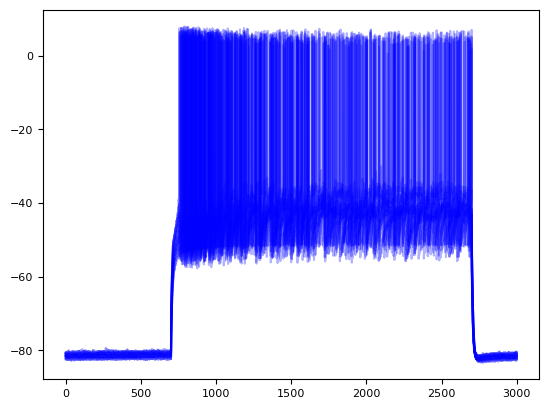

[716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733]
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733


/home/abonard/anaconda3/lib/python3.12/site-packages/efel/pyfeatures/cppfeature_access.py:14: RuntimeWarning: Error while calculating adaptation_index2, Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting fu

[({'sweep': 'IDthresh_716', 'holding_current_amp': 182.8875, 'holding_current_start': 0.0, 'holding_current_end': 2999.9, 'stimulus_total_amp': 292.74008650865085, 'stimulus_amp': 109.85258650865086, 'stimulus_start': 100, 'stimulus_end': 1100}, {'AHP_depth': array([24.698197, 25.004497, 25.510797, 25.998197, 25.998197, 26.154497,
       26.223297, 26.254497, 26.610797, 26.860797]), 'AHP_depth_abs': array([-67.2188, -66.9125, -66.4062, -65.9188, -65.9188, -65.7625,
       -65.6937, -65.6625, -65.3062, -65.0562]), 'AHP_depth_abs_slow': array([-65.3312, -65.1188, -64.6062, -64.7625, -64.5187, -64.3812,
       -64.1688, -64.575 ]), 'AHP_slow_time': array([0.06498195, 0.04678363, 0.05300714, 0.03703704, 0.04006047,
       0.01410008, 0.0147468 , 0.03109509]), 'AHP_time_from_peak': array([1.1, 1. , 1.1, 0.9, 0.9, 1.1, 1. , 1. , 1.2, 1.2]), 'AP_amplitude': array([44.74374996, 46.18119999, 44.46875   ]), 'AP_begin_voltage': array([-49.11249998, -49.7812    , -49.75      , -47.9125    ,
      

In [32]:
from scipy.signal import find_peaks

cell_type = 'FS'
cell_path = 'fs/derived/'
cell_id = '161205_FS1'
cell = cell_path + cell_id
prefix = 'ECall'
channels = {'current': 2, 'voltage': 3}
liquid_junction_potential = 9.5

spec = {}
spec['cell_id'] = cell_id
spec['cell_type'] = cell_type
spec['cell_features'] = {}
spec['temperature'] = 35
spec['liquid_junction_potential'] = liquid_junction_potential

protocol = 'IDthresh'
feature_protocol = protocol
path = cell
vshift=0
input_resistance=False

list_rec = []
for rec in  range(713, 734):
    fullname = path + '/' + prefix + '_' + protocol \
    + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
    data = np.loadtxt(fullname)
    time = data[:, 0]
    voltage = data[:, 1]
    peak_tuple = find_peaks(voltage, height= -30)
    if peak_tuple[0].size > 1:
        list_rec.append(rec)
        plt.plot(time,voltage, 'b', alpha=0.3)
plt.show()

repetitions = [list_rec]  
print(list_rec)
features_train = ['AHP_depth', 'AHP_depth_abs', 'AHP_depth_abs_slow',
                  'AHP_slow_time', 'AHP_time_from_peak', 'AP_amplitude',
                  'AP_begin_voltage', 'AP_fall_rate', 'AP_rise_rate', 
                  'ISI_CV', 'Spikecount', 'adaptation_index2', 
                  'inv_first_ISI', 'mean_frequency',
                  'min_voltage_between_spikes', 'peak_voltage',
                  'spike_half_width', 'steady_state_voltage', 
                  'time_to_first_spike', 'voltage_base']
features = features_train

spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, path, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 1100},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)
print(spec['cell_features'][feature_protocol])    

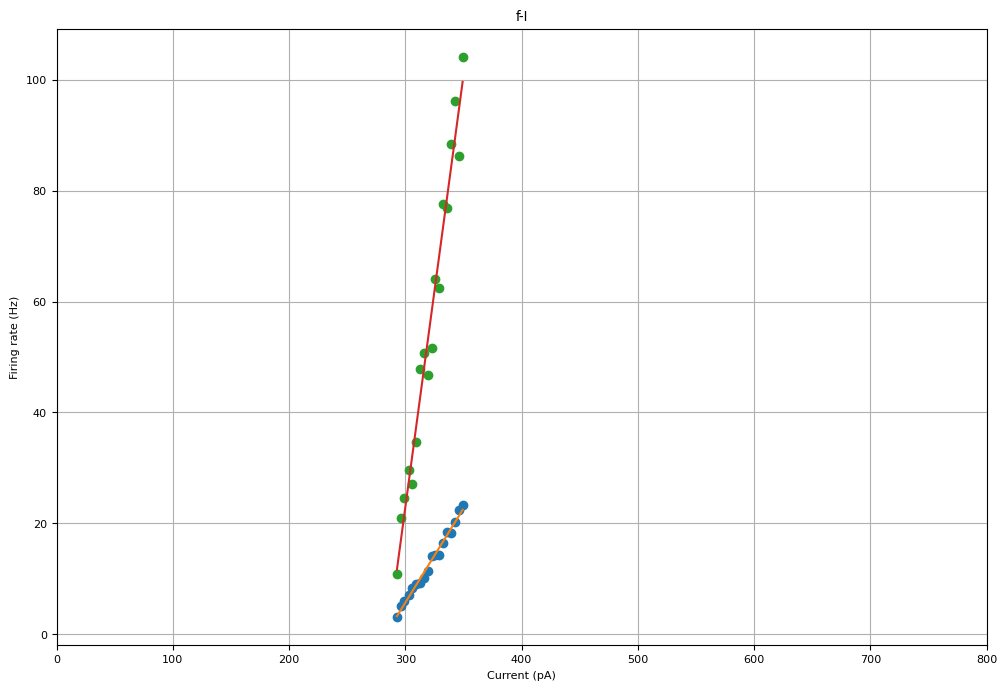

In [41]:
f_i4 = []
f_i14 = []
for stim, feat in spec['cell_features']['IDthresh']:
    f_i4.append((stim['stimulus_total_amp'], feat['mean_frequency'][0]))
    f_i14.append((stim['stimulus_total_amp'], feat['inv_first_ISI'][0]))
f_i4.sort(key=lambda x: x[0])
f_i14.sort(key=lambda x: x[0])

fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('f-I')
ax.grid()
xx = np.array([x[0] for x in f_i4])
yy = np.array([x[1] for x in f_i4])
p = np.polyfit(xx, yy, 1)
ax.plot(xx, yy, 'o')
ax.plot(xx, p[1]+p[0]*xx, '-')
x1 = np.array([x[0] for x in f_i14])
y1 = np.array([x[1] for x in f_i14])
p1 = np.polyfit(x1, y1, 1)
ax.plot(x1, y1, 'o')
ax.plot(x1, p1[1]+p1[0]*x1, '-')
plt.xlim(0,800)
plt.show()

In [34]:
print(f_i)
print(f_i2)
print(f_i3)
print(f_i4)
print('-------')
print(f_i1)
print(f_i12)
print(f_i13)
print(f_i14)


[(347.4408065806581, -0.0), (349.94543204320433, -0.0), (352.5977597759776, 2.244668911335183), (355.04175417541757, 4.115649758205066), (357.551505150515, 4.225649693639756), (360.17814281428144, 2.144772117962107), (362.6514526452645, 6.03378921962932), (365.17889288928893, 6.155740227761643), (367.7860911091109, 6.285355122563527), (370.19395689568955, 7.345225603356756), (372.9097284728473, 8.073468563930938)]
[(102.00176267626763, 2.3463162834345996), (104.7735398539854, 4.309880400818132), (107.45868336833684, 7.291666666665669), (110.01762676267627, 9.176182707992423), (112.80321782178218, 10.081661457807206), (115.45323282328233, 12.207527975583572), (118.04849234923492, 14.164305949006986), (120.80414291429143, 15.312372396894917), (123.55516801680169, 17.239630869078333), (126.05560556055606, 18.341145302626806), (128.79725472547256, 20.038072337439196), (131.55165516551656, 20.379050336252007), (134.21992199219923, 23.251112009702346), (136.92875537553755, 24.1400120700036),

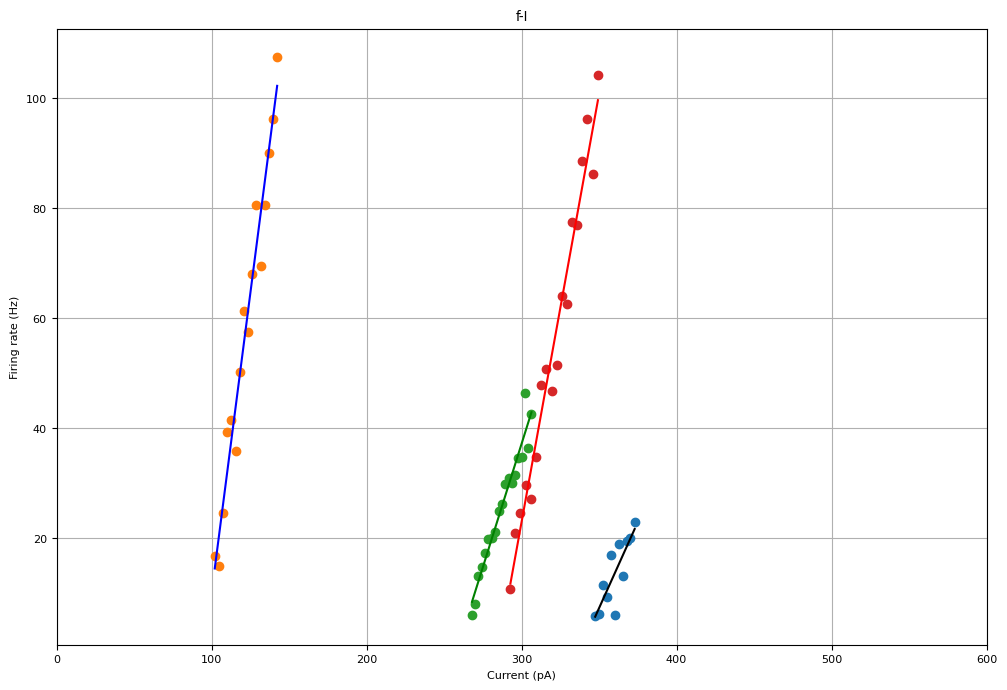

In [43]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('f-I')
ax.grid()

x1 = np.array([x[0] for x in f_i1])
y1 = np.array([x[1] for x in f_i1])
p1 = np.polyfit(x1, y1, 1)
ax.plot(x1, y1, 'o')
ax.plot(x1, p1[1]+p1[0]*x1, 'k-')

x2 = np.array([x[0] for x in f_i12])
y2 = np.array([x[1] for x in f_i12])
p2 = np.polyfit(x2, y2, 1)
ax.plot(x2, y2, 'o')
ax.plot(x2, p2[1]+p2[0]*x2, 'b-')

x3 = np.array([x[0] for x in f_i13])
y3 = np.array([x[1] for x in f_i13])
p3 = np.polyfit(x3, y3, 1)
ax.plot(x3, y3, 'o')
ax.plot(x3, p3[1]+p3[0]*x3, 'g-')

x4 = np.array([x[0] for x in f_i14])
y4 = np.array([x[1] for x in f_i14])
p4 = np.polyfit(x4, y4, 1)
ax.plot(x4, y4, 'o')
ax.plot(x4, p4[1]+p4[0]*x4, 'r-')

plt.xlim(0,600)
plt.show()